In [1]:
!pip install --no-deps simplejson
!pip install --no-deps citylearn==1.8.0
# !pip install --upgrade ipykernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 12.9 MB/s eta 0:00:00


In [2]:
# system files
import sys, os

# type hinting
from typing import List, Mapping

# Data visualization
import time
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# CityLearn
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet

# custom modules
cwd = '/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC'
sys.path.append(os.path.join(cwd))
from preprocessing import set_schema_buildings, set_schema_simulation_period, set_active_observations, get_timestep
from plot_kpi import plot_simulation_summary, plot_actions, plot_rewards

%matplotlib inline

In [3]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet.get_schema(DATASET_NAME)

root_directory = schema['root_directory']

In [ ]:
[1,2,3,4,5,6,7,8,9,10,11,13,14,16,17]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17]

In [4]:
# edit next code line to change number of buildings in simulation
BUILDING_INDEX = [7]

# edit next code line to change active observations in simulation
ACTIVE_OBSERVATIONS = ['month',
                       'day_type',
                       'hour',
                       'diffuse_solar_irradiance',
                       'diffuse_solar_irradiance_predicted_6h',
                       'diffuse_solar_irradiance_predicted_12h',
                       'direct_solar_irradiance',
                       'direct_solar_irradiance_predicted_6h',
                       'direct_solar_irradiance_predicted_12h',
                       'carbon_intensity',
                       'non_shiftable_load',
                       'solar_generation',
                       'electrical_storage_soc',
                       ]

schema, buildings = set_schema_buildings(schema, BUILDING_INDEX)
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)

print('Selected buildings:', buildings)
print(f'Active observations:', ACTIVE_OBSERVATIONS)

Selected buildings: ['Building_7']
Active observations: ['month', 'day_type', 'hour', 'diffuse_solar_irradiance', 'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'direct_solar_irradiance', 'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'carbon_intensity', 'non_shiftable_load', 'solar_generation', 'electrical_storage_soc']


In [5]:
# set pricing obervation to shared
# デフォルトだと、電力料金は住宅ごとで分かれているため、ひとつにまとめる
pricing_obs = ['electricity_pricing',
               'electricity_pricing_predicted_6h',
               'electricity_pricing_predicted_12h',
               'electricity_pricing_predicted_24h']

for ob in pricing_obs:
    schema["observations"][ob]['shared_in_central_agent']=True

In [6]:
# １つのAgentですべての住宅を制御
schema['central_agent'] = True

In [7]:
# Training Timestep
START = get_timestep(8,1,0)
STOP = get_timestep(5,31,23)

schema = set_schema_simulation_period(schema,
                                      START, STOP)

print(f'Selected time steps:', (START, STOP))

Selected time steps: (0, 7295)


In [8]:
analysis_schema = schema.copy()

# Testing timestep
START = get_timestep(6,5,1)
STOP = get_timestep(6,6,0)

analysis_schema = set_schema_simulation_period(analysis_schema,
                                               START, STOP)

print(f'Selected time steps:', (START, STOP))

Selected time steps: (7393, 7416)


# MPC

In [ ]:
import numpy as np
import os, joblib

# type hinting
from typing import Any, List, Mapping, Tuple

from preprocessing import get_datetime, set_schema_simulation_period
from electric_pricing import generate_24_price

from citylearn.agents.base import Agent
from citylearn.citylearn import CityLearnEnv

class MPC(Agent):
    def __init__(self, schema: dict, env: CityLearnEnv,
                 model_folder: str,
                 lookback: int = 12, horizon: int = 24,
                 **kwargs: Any):
        super().__init__(env, **kwargs)
        self.schema = schema
        self.env = env
        self.lookback = lookback
        self.horizon = horizon
        self.b_names = [b.name for b in self.env.buildings]
        self.current_timestep = self.env.simulation_start_time_step

        # load prediction models
        self.model_folder = model_folder
        self.load_predictor = self._load_models("load_12.pkl")
        self.gen_predictor = self._load_models("gen_12.pkl")
        self.netelec_predictor = self._load_models("netelec.pkl")
        self.carbon_predictor = joblib.load(os.path.join(self.model_folder,"carbon.pkl"))

        # initalize dictionaries
        self.previous_states = {b_name: {"non_shiftable_load":np.zeros(13),"solar_generation":np.zeros(13)} for b_name in self.b_names}
        self.current_SoC = {b_name: b.observations()["electrical_storage_soc"] for b,b_name in zip(self.env.buildings,self.b_names)}
        self.future_states = {b_name: {"non_shiftable_load":[],"solar_generation":[]} for b_name in self.b_names}
        self.baseline_net_electricity = {b: [] for b in self.b_names}

        self._future_actions = {b_name: np.zeros(self.horizon) for b_name in self.b_names}
        self.future_net_electricity = {b: [] for b in self.b_names}

        # update dictionaries for initial step
        self._warmup(self.lookback)
        self._predict_future_states()

    @property
    def future_actions(self):
        return self._future_actions

    @future_actions.setter
    def future_actions(self, future_actions: dict):
        self._future_actions = future_actions
        self.predict_net_electricity()

    def _load_models(self, model_name: str):
        models = {}
        for b_name in self.b_names:
            models[b_name] = joblib.load(os.path.join(
                self.model_folder,b_name,model_name))
        return models

    def _warmup(self, warmup_timesteps: int):
        warmup_schema = self.schema.copy()
        stop_time = self.schema['simulation_start_time_step']
        start_time = stop_time - warmup_timesteps
        warmup_schema = set_schema_simulation_period(warmup_schema,
                                                     start_time,
                                                     stop_time)
        warmup_env = CityLearnEnv(warmup_schema)
        for b in warmup_env.buildings:
            self.previous_states[b.name]["non_shiftable_load"][0] = b.observations()["non_shiftable_load"]
            self.previous_states[b.name]["solar_generation"][0] = b.observations()["solar_generation"]

        while not warmup_env.done:
            actions = np.zeros(len(self.b_names))
            warmup_env.step([actions])
            for b in warmup_env.buildings:
                self.previous_states[b.name]["non_shiftable_load"][warmup_env.time_step] = b.observations()["non_shiftable_load"]
                self.previous_states[b.name]["solar_generation"][warmup_env.time_step] = b.observations()["solar_generation"]

    def _load_input(self, b_name):
        input_features = ['month', 'day_type', 'hour']
        input_features = np.array([self.env.buildings[0].observations()[k] for k in input_features])
        prev_state = self.previous_states[b_name]["non_shiftable_load"]
        return np.concatenate((input_features,prev_state), axis=0).reshape(1,-1)

    def _gen_input(self, b_name):
        input_features = ['month', 'day_type', 'hour',
                          "diffuse_solar_irradiance","diffuse_solar_irradiance_predicted_6h","diffuse_solar_irradiance_predicted_12h",
                          "direct_solar_irradiance", "direct_solar_irradiance_predicted_6h", "direct_solar_irradiance_predicted_12h"]
        input_features = np.array([self.env.buildings[0].observations()[k] for k in input_features])
        prev_state = self.previous_states[b_name]["solar_generation"]
        return np.concatenate((input_features,prev_state), axis=0).reshape(1,-1)

    def _predict_future_states(self):
        for b in self.b_names:
            self.future_states[b]["non_shiftable_load"] = self.load_predictor[b].predict(self._load_input(b))[0]
            self.future_states[b]["solar_generation"] = self.gen_predictor[b].predict(self._gen_input(b))[0]

            self.baseline_net_electricity[b] = self.future_states[b]["non_shiftable_load"] - self.future_states[b]["solar_generation"]

    def _update_current_SoC(self):
        for b in self.env.buildings:
            self.current_SoC[b.name] = b.observations()["electrical_storage_soc"]

    def _update_array(self, arr, new_value):
        arr[:-1] = arr[1:]
        arr[-1] = new_value

    def _update_previous_states(self):
        for b in self.env.buildings:
            self._update_array(self.previous_states[b.name]["non_shiftable_load"], b.observations()["non_shiftable_load"])
            self._update_array(self.previous_states[b.name]["solar_generation"], b.observations()["solar_generation"])

    def update_mpc(self):
        self._update_current_SoC()
        self._update_previous_states()
        self._predict_future_states()
        self.current_timestep += 1

    @property
    def future_electricity_pricing(self):
        return np.array(generate_24_price(get_datetime(self.current_timestep)))

    @property
    def future_carbon_intensity(self):
        input_features = ['month', 'day_type', 'hour', 'carbon_intensity']
        input = np.array([[self.env.buildings[0].observations()[k] for k in input_features]])
        return self.carbon_predictor.predict(input)[0]

    def predict_net_electricity(self):
        for b_name in self.b_names:
            netelecs = []
            soc = self.current_SoC[b_name]
            for i in range(self.horizon):
                load = self.future_states[b_name]["non_shiftable_load"][i]
                gen = self.future_states[b_name]["solar_generation"][i]
                act = self.future_actions[b_name][i]
                soc, netelec = self.netelec_predictor[b_name].predict([[load,gen,soc,act]])[0]
                netelecs.append(netelec)
            self.future_net_electricity[b_name] = np.array(netelecs)

    @property
    def control_total_net_electricity(self):
        return sum(self.future_net_electricity[b] for b in self.b_names)

    @property
    def baseline_total_net_electricity(self):
        return sum(self.baseline_net_electricity[b] for b in self.b_names)

    @property
    def energy_score(self):
        control = np.sum(self.control_total_net_electricity)
        baseline = np.sum(self.baseline_total_net_electricity)
        return control/baseline

    @property
    def price_score(self):
        control = np.dot(self.control_total_net_electricity,self.future_electricity_pricing)
        baseline = np.dot(self.baseline_total_net_electricity,self.future_electricity_pricing)
        return control/baseline

    @property
    def carbon_score(self):
        control = np.dot(np.maximum(self.control_total_net_electricity,0),self.future_carbon_intensity)
        baseline = np.dot(np.maximum(self.baseline_total_net_electricity,0),self.future_carbon_intensity)
        return control/baseline

    @property
    def average_score(self):
        return (self.energy_score + self.price_score + self.carbon_score)/3

# optimizer

# Differential evolution

In [ ]:
mpc_env = CityLearnEnv(analysis_schema)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [ ]:
mpc = MPC(analysis_schema,mpc_env,
          model_folder = os.path.join(cwd,"models"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more inf

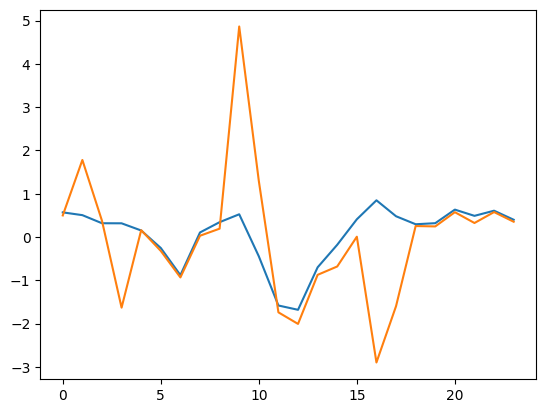

In [ ]:
plt.plot(mpc.baseline_total_net_electricity)
plt.plot(mpc.control_total_net_electricity)

In [ ]:
def predict_net_electricity(actions):
    pop = next(iter(actions.values())).shape[0] # replace with self.pop

    results = {}
    soc_hist = {}

    for b_name in mpc.b_names:
        netelecs = []
        socs = [np.full(pop, mpc.current_SoC[b_name])]
        for i in range(mpc.horizon):
            loads = np.full(pop, mpc.future_states[b_name]["non_shiftable_load"][i])
            gens = np.full(pop, mpc.future_states[b_name]["solar_generation"][i])
            acts = actions[b_name][:,i]
            predicts = mpc.netelec_predictor[b_name].predict(np.array([loads,gens,socs[-1],acts]).T)
            socs.append(predicts[:,0])
            netelecs.append(predicts[:,1])
        results[b_name] = np.array(netelecs).T
        soc_hist[b_name] = np.array(socs).T
    return results, soc_hist

In [ ]:
def total_net_electricity(nets):
    return sum(nets[b] for b in mpc.b_names)

def energy_score(total_nets):
    control = np.sum(total_nets, axis=1)
    baseline = np.sum(mpc.baseline_total_net_electricity)
    return control/baseline

def price_score(total_nets):
    control = np.dot(total_nets,mpc.future_electricity_pricing)
    baseline = np.dot(mpc.baseline_total_net_electricity,mpc.future_electricity_pricing)
    return control/baseline

def carbon_score(total_nets):
    control = np.dot(np.maximum(total_nets,0),mpc.future_carbon_intensity)
    baseline = np.dot(np.maximum(mpc.baseline_total_net_electricity,0),mpc.future_carbon_intensity)
    return control/baseline

def average_score(total_nets):
    energy = energy_score(total_nets)
    price = price_score(total_nets)
    carbon = carbon_score(total_nets)
    return (energy + price + carbon)/3

In [ ]:
def mutate(x, F):
    return x[0] + F * ((x[1] + x[2]) - (x[3] + x[4]))

def crossover(mutated, target, dims, cr):
    p = np.random.rand(dims)
    trial = np.where(p < cr, mutated, target)
    return trial

def generate_new_actions(state, actions, best_action, pop, genes, mut, cr):
    indices = np.array([np.random.choice(np.arange(pop), size=4, replace=False) for _ in range(pop)])
    a, b, c, d = actions[indices.T]

    mutated = mutate((best_action, a, b, c, d), mut)
    mutated = np.clip(mutated, a_min=-0.78125, a_max=0.78125)

    trial = crossover(mutated, actions, genes, cr)

    return trial

In [ ]:
def generate_population(state, pop, genes, lower_bound=-0.78125, upper_bound=0.78125):
    actions = []
    state = np.full(pop, state)

    for _ in range(genes):
        action = np.random.uniform(np.maximum(-1 * state, lower_bound), np.minimum(1 - state, upper_bound), size=(pop))
        actions.append(action)
        state += action

    return np.array(actions).T

In [ ]:
def root_square_deci_penalty(arr1, arr2):
    return np.sum(np.sqrt((((arr1-arr2)*10)**2)/10),axis=1)

In [ ]:
def root_square_penalty(arr1, arr2):
    return np.sum(np.sqrt((arr1-arr2)**2),axis=1)

In [ ]:
def abs_penalty(arr1, arr2):
    return np.sum(np.abs(arr1-arr2),axis=1)

In [ ]:
def penalty_function(actions, soc):
    penalty = 0
    for b_name in mpc.b_names:
        expected = actions[b_name] + soc[b_name][:, :24]
        penalty += abs_penalty(expected, soc[b_name][:, 1:])
    return penalty

### test

In [ ]:
state = 0.0
pop = 50
genes = 24
mut = 0.5
cr = 0.7

actions = {'Building_7': generate_population(mpc.current_SoC['Building_7'], pop, mpc.horizon)}
net, soc = predict_net_electricity(actions)
total_net = total_net_electricity(net)
scores = average_score(total_net) + penalty_function(actions, soc)

In [ ]:
best_action = {'Building_7': actions['Building_7'][np.argmin(scores)]}
best_obj_hist = [min(scores)]

In [ ]:
for i in range(100):
    new_actions = generate_new_actions(state, actions['Building_7'], best_action['Building_7'], pop, genes, mut, cr)

    new_actions = {'Building_7':new_actions}
    net,soc = predict_net_electricity(new_actions)
    total_net = total_net_electricity(net)
    new_scores = average_score(total_net) + penalty_function(new_actions, soc)

    update_mask = new_scores < scores
    actions['Building_7'][update_mask] = new_actions['Building_7'][update_mask]
    scores[update_mask] = new_scores[update_mask]

    best_action = {'Building_7': actions['Building_7'][np.argmin(scores)]}
    best_obj_hist.append(min(scores))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


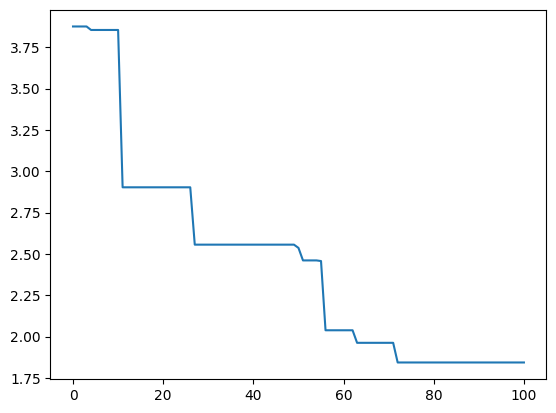

In [ ]:
plt.plot(best_obj_hist)

In [ ]:
avg_score = average_score(total_net)
penalty = penalty_function(actions, soc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


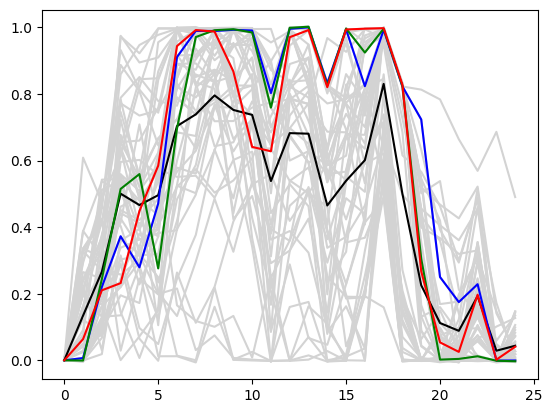

In [ ]:
[plt.plot(soc['Building_7'][i], c='lightgray') for i in range(50)];
plt.plot(np.mean(soc['Building_7'], axis=0), c='black')
plt.plot(soc['Building_7'][np.argmin(scores)], c='blue')
plt.plot(soc['Building_7'][np.argmin(avg_score)], c='green')
plt.plot(soc['Building_7'][np.argmin(penalty)], c='red')

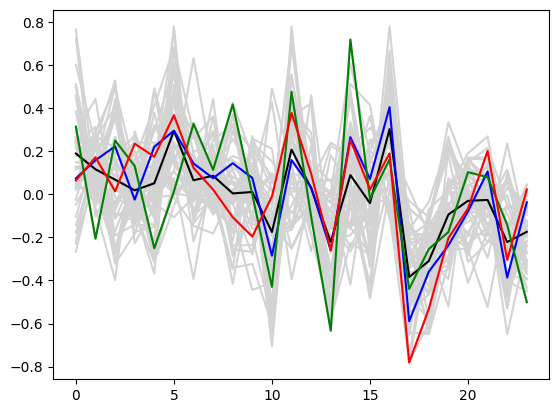

In [ ]:
[plt.plot(actions['Building_7'][i], c='lightgray') for i in range(50)];
plt.plot(np.mean(actions['Building_7'], axis=0), c='black')
plt.plot(actions['Building_7'][np.argmin(scores)], c='blue')
plt.plot(actions['Building_7'][np.argmin(avg_score)], c='green')
plt.plot(actions['Building_7'][np.argmin(penalty)], c='red')

# MPC with DE

In [ ]:
import numpy as np
import os, joblib

# type hinting
from typing import Any, List, Mapping, Tuple

from preprocessing import get_datetime, set_schema_simulation_period
from electric_pricing import generate_24_price

from citylearn.agents.base import Agent
from citylearn.citylearn import CityLearnEnv

class MPC(Agent):
    def __init__(self, schema: dict, env: CityLearnEnv,
                 model_folder: str,
                 lookback: int = 12, horizon: int = 24,
                 pop: int = 50,
                 **kwargs: Any):
        super().__init__(env, **kwargs)
        self.schema = schema
        self.env = env
        self.lookback = lookback
        self.horizon = horizon
        self.b_names = [b.name for b in self.env.buildings]
        self.current_timestep = self.env.simulation_start_time_step
        self.pop = pop

        # load prediction models
        self.model_folder = model_folder
        self.load_predictor = self._load_models("load_12.pkl")
        self.gen_predictor = self._load_models("gen_12.pkl")
        self.netelec_predictor = self._load_models("netelec.pkl")
        self.carbon_predictor = joblib.load(os.path.join(self.model_folder,"carbon.pkl"))

        # initalize dictionaries
        self.previous_states = {b_name: {"non_shiftable_load":np.zeros(self.lookback+1),"solar_generation":np.zeros(self.lookback+1)} for b_name in self.b_names}
        self.current_SoC = {b_name: b.observations()["electrical_storage_soc"] for b,b_name in zip(self.env.buildings,self.b_names)}
        self.future_states = {b_name: {"non_shiftable_load":[],"solar_generation":[]} for b_name in self.b_names}
        self.baseline_net_electricity = {b: [] for b in self.b_names}

        self._future_actions = {b_name: np.zeros(self.horizon) for b_name in self.b_names}
        self.future_net_electricity = {b: [] for b in self.b_names}

        # update dictionaries for initial step
        self._warmup(self.lookback)
        self._predict_future_states()

    @property
    def low_bound(self):
        return self.env.action_space[0].low[0]

    @property
    def high_bound(self):
        return self.env.action_space[0].high[0]

    @property
    def future_actions(self):
        return self._future_actions

    @future_actions.setter
    def future_actions(self, future_actions: dict):
        self._future_actions = future_actions

    def _load_models(self, model_name: str):
        models = {}
        for b_name in self.b_names:
            models[b_name] = joblib.load(os.path.join(
                self.model_folder,b_name,model_name))
        return models

    def _warmup(self, warmup_timesteps: int):
        warmup_schema = self.schema.copy()
        stop_time = self.schema['simulation_start_time_step']
        start_time = stop_time - warmup_timesteps
        warmup_schema = set_schema_simulation_period(warmup_schema,
                                                     start_time,
                                                     stop_time)
        warmup_env = CityLearnEnv(warmup_schema)
        for b in warmup_env.buildings:
            self.previous_states[b.name]["non_shiftable_load"][0] = b.observations()["non_shiftable_load"]
            self.previous_states[b.name]["solar_generation"][0] = b.observations()["solar_generation"]

        while not warmup_env.done:
            actions = np.zeros(len(self.b_names))
            warmup_env.step([actions])
            for b in warmup_env.buildings:
                self.previous_states[b.name]["non_shiftable_load"][warmup_env.time_step] = b.observations()["non_shiftable_load"]
                self.previous_states[b.name]["solar_generation"][warmup_env.time_step] = b.observations()["solar_generation"]

    def _load_input(self, b_name):
        input_features = ['month', 'day_type', 'hour']
        input_features = np.array([self.env.buildings[0].observations()[k] for k in input_features])
        prev_state = self.previous_states[b_name]["non_shiftable_load"]
        return np.concatenate((input_features,prev_state), axis=0).reshape(1,-1)

    def _gen_input(self, b_name):
        input_features = ['month', 'day_type', 'hour',
                          "diffuse_solar_irradiance","diffuse_solar_irradiance_predicted_6h","diffuse_solar_irradiance_predicted_12h",
                          "direct_solar_irradiance", "direct_solar_irradiance_predicted_6h", "direct_solar_irradiance_predicted_12h"]
        input_features = np.array([self.env.buildings[0].observations()[k] for k in input_features])
        prev_state = self.previous_states[b_name]["solar_generation"]
        return np.concatenate((input_features,prev_state), axis=0).reshape(1,-1)

    def _predict_future_states(self):
        for b_name in self.b_names:
            self.future_states[b_name]["non_shiftable_load"] = self.load_predictor[b_name].predict(self._load_input(b_name))[0]
            self.future_states[b_name]["solar_generation"] = self.gen_predictor[b_name].predict(self._gen_input(b_name))[0]

            self.baseline_net_electricity[b_name] = self.future_states[b_name]["non_shiftable_load"] - self.future_states[b_name]["solar_generation"]

    def _update_current_SoC(self):
        for b in self.env.buildings:
            self.current_SoC[b.name] = b.observations()["electrical_storage_soc"]

    def _update_array(self, arr, new_value):
        arr[:-1] = arr[1:]
        arr[-1] = new_value

    def _update_previous_states(self):
        for b in self.env.buildings:
            self._update_array(self.previous_states[b.name]["non_shiftable_load"], b.observations()["non_shiftable_load"])
            self._update_array(self.previous_states[b.name]["solar_generation"], b.observations()["solar_generation"])

    def update_mpc(self):
        self._update_current_SoC()
        self._update_previous_states()
        self._predict_future_states()
        self.current_timestep += 1

    @property
    def future_electricity_pricing(self):
        return np.array(generate_24_price(get_datetime(self.current_timestep)))

    @property
    def future_carbon_intensity(self):
        input_features = ['month', 'day_type', 'hour', 'carbon_intensity']
        input = np.array([[self.env.buildings[0].observations()[k] for k in input_features]])
        return self.carbon_predictor.predict(input)[0]

    @property
    def baseline_total_net_electricity(self):
        return sum(self.baseline_net_electricity[b] for b in self.b_names)

    # Evaluation
    def predict_net_electricity(self, actions):
        results = {}
        soc_hist = {}

        for b_name in self.b_names:
            netelecs = []
            socs = [np.full(self.pop, self.current_SoC[b_name])]
            for i in range(self.horizon):
                loads = np.full(self.pop, self.future_states[b_name]["non_shiftable_load"][i])
                gens = np.full(self.pop, self.future_states[b_name]["solar_generation"][i])
                acts = actions[b_name][:,i]
                predicts = self.netelec_predictor[b_name].predict(np.array([loads,gens,socs[-1],acts]).T)
                socs.append(predicts[:,0])
                netelecs.append(predicts[:,1])
            results[b_name] = np.array(netelecs).T
            soc_hist[b_name] = np.array(socs).T
        return results, soc_hist

    def total_net_electricity(self, netelecs):
        return sum(netelecs[b] for b in self.b_names)

    def energy_score(self, total_nets):
        control = np.sum(total_nets, axis=1)
        baseline = np.sum(self.baseline_total_net_electricity)
        return control/baseline

    def price_score(self, total_nets):
        control = np.dot(total_nets, self.future_electricity_pricing)
        baseline = np.dot(self.baseline_total_net_electricity, self.future_electricity_pricing)
        return control/baseline

    def carbon_score(self, total_nets):
        control = np.dot(np.maximum(total_nets,0), self.future_carbon_intensity)
        baseline = np.dot(np.maximum(self.baseline_total_net_electricity,0), self.future_carbon_intensity)
        return control/baseline

    def average_score(self, total_nets):
        energy = self.energy_score(total_nets)
        price = self.price_score(total_nets)
        carbon = self.carbon_score(total_nets)
        return (energy + price + carbon)/3

    # optimizer
    def _generate_population(self):
        population = {}
        for b_name in self.b_names:
            actions = []
            state = np.full(self.pop, self.current_SoC[b_name])
            for _ in range(self.horizon):
                action = np.random.uniform(np.maximum(-1 * state, self.low_bound), np.minimum(1 - state, self.high_bound), size=(self.pop))
                actions.append(action)
                state += action
            population[b_name] = np.array(actions).T
        return population

    # best/2/bin
    def _mutate(self, x, F):
        return x[0] + F * ((x[1] + x[2]) - (x[3] + x[4]))

    def _crossover(self, mutated, target, dims, cr):
        p = np.random.rand(dims)
        trial = np.where(p < cr, mutated, target)
        return trial

    def _generate_new_actions(self, actions, mut=0.5, cr=0.7):
        all_actions = np.concatenate([actions[b_name] for b_name in self.b_names],axis=1)
        all_best = np.concatenate([self.future_actions[b_name] for b_name in self.b_names])

        indices = np.array([np.random.choice(np.arange(self.pop), size=4, replace=False) for _ in range(self.pop)])
        a, b, c, d = all_actions[indices.T]

        mutated = self._mutate((all_best, a, b, c, d), 0.5)
        mutated = np.clip(mutated, a_min=-0.78125, a_max=0.78125)

        trial = self._crossover(mutated, all_actions, self.horizon*len(self.b_names), 0.7)
        new_actions = {b_name: np.split(trial,len(self.b_names),axis=1)[i] for i,b_name in enumerate(self.b_names)}
        return new_actions

    def _penalty_function(self, actions, soc):
        penalty = 0
        for b_name in self.b_names:
            expected = actions[b_name] + soc[b_name][:, :24]
            penalty += np.sum(np.abs(expected - soc[b_name][:, 1:]), axis=1)
        return penalty

    def _update_actions(self, actions, new_actions, update_mask):
        for b_name in self.b_names:
            actions[b_name][update_mask] = new_actions[b_name][update_mask]

    def optimize(self, generations):
        actions = self._generate_population()
        net, soc = self.predict_net_electricity(actions)
        total_net = self.total_net_electricity(net)
        scores = self.average_score(total_net)  # + self._penalty_function(actions, soc)
        self.future_actions = {b_name: actions[b_name][np.argmin(scores)] for b_name in self.b_names}
        best_obj_hist = [min(scores)]

        for i in range(generations):
            new_actions = self._generate_new_actions(actions, self.future_actions)

            net,soc = self.predict_net_electricity(new_actions)
            total_net = self.total_net_electricity(net)
            new_scores = self.average_score(total_net) + self._penalty_function(new_actions, soc)

            update_mask = new_scores < scores
            self._update_actions(actions, new_actions, update_mask)
            scores[update_mask] = new_scores[update_mask]

            self.future_actions = {b_name: actions[b_name][np.argmin(scores)] for b_name in self.b_names}
            best_obj_hist.append(min(scores))
        return best_obj_hist

    def predict_mpc(self):
        # _ = self.optimize(generations)
        return [self.future_actions[b_name][0] for b_name in self.b_names]

    def reset_mpc(self):
        self.current_timestep = self.env.simulation_start_time_step

        # initalize dictionaries
        self.previous_states = {b_name: {"non_shiftable_load":np.zeros(self.lookback+1),"solar_generation":np.zeros(self.lookback+1)} for b_name in self.b_names}
        self.current_SoC = {b_name: b.observations()["electrical_storage_soc"] for b,b_name in zip(self.env.buildings,self.b_names)}
        self.future_states = {b_name: {"non_shiftable_load":[],"solar_generation":[]} for b_name in self.b_names}
        self.baseline_net_electricity = {b_name: [] for b_name in self.b_names}

        self._future_actions = {b_name: np.zeros(self.horizon) for b_name in self.b_names}
        self.future_net_electricity = {b_name: [] for b_name in self.b_names}

        # update dictionaries for initial step
        self._warmup(self.lookback)
        self._predict_future_states()

In [ ]:
mpc_env = CityLearnEnv(analysis_schema)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [ ]:
mpc_de = MPC(analysis_schema,mpc_env,
          model_folder = os.path.join(cwd,"models"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more inf

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (D

Building-level KPIs:


/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/plot_kpi.py:115: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


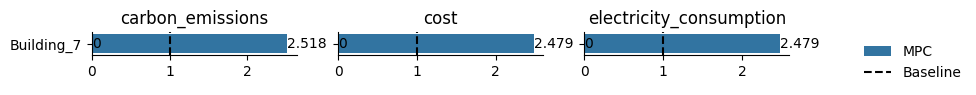

Building-level load profiles:


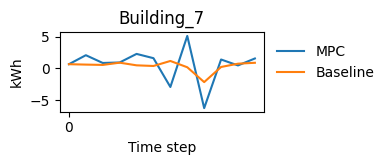

Battery SoC profiles:


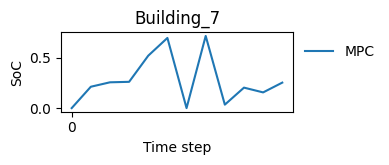

District-level KPIs:


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (D

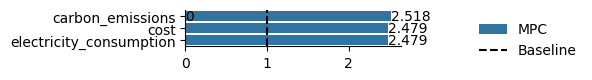

District-level load profiles:


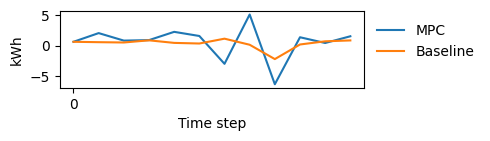

In [ ]:
observations = mpc_env.reset()
actions_list = []
observations_list = []
hist_list = []

while not mpc_env.done:
    observations_list.append(observations)
    hist = mpc_de.optimize(generations=5000)
    hist_list.append(hist)
    actions = mpc_de.predict_mpc()
    actions_list.append(actions)
    observations, _, _, _ = mpc_env.step([actions])
    mpc_de.update_mpc()

plot_simulation_summary(
    {'MPC': mpc_env}
)

In [ ]:
np.savetxt(os.path.join(cwd, "actions.txt"), np.array(actions_list), delimiter=",")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
np.savetxt(os.path.join(cwd, "observations.txt"), np.array(observations_list).reshape(-1,13), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "history.txt"), np.array(hist_list), delimiter=",")

# reference code

In [ ]:
class MPCController:
    def __init__(self, horizon):
        self.horizon = horizon  # MPC horizon (planning steps)

    def cost_function(self, action, state):
        # Define a cost function based on action
        return np.sum(np.square(action))

    def predict(self, state):
        # Forest the future state based on current state
        return np.random.randn(self.horizon)

    def mpc(self, state):
        def objective(action):
            total_cost = 0
            for i in range(self.horizon):
                future_state = self.predict(state)[i]
                total_cost += self.cost_function(action[i], future_state)
            return total_cost

        # Initialize control sequence randomly
        initial_guess = np.random.randn(self.horizon)

        # Solve the optimization problem
        result = minimize(objective, initial_guess)
        return result.x[0]  # Return the first action from the optimized sequence

# Create MPC controller instance
mpc_controller = MPCController(horizon=10)

In [ ]:

observations = mpc_env.reset()

while not mpc_env.done:
    actions = mpc_controller.mpc(observations)
    observations, reward, _, _ = mpc_env.step([actions])